In [1084]:
# importing libraries.
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import random 
import string
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [1085]:
# Campaign related tables
campaign_desc = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\campaign_desc.csv")
campaign_table = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\campaign_table.csv")

# Coupon related tables
coupon = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\coupon.csv")
coupon_redempt = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\coupon_redempt.csv")

# Product related tables
casual_data = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\causal_data.csv")
product = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\product.csv")

# Customer/ Transaction related tables
hh_demographic = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\hh_demographic.csv")
transaction_data = pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\transaction_data.csv")

In [1086]:
t=['campaign_desc','campaign_table','causal_data','coupon','coupon_redempt','hh_demographic','product','transaction_data']
l=[]
x=[]
# Extracted_tables_info => tables generated throughout the file and there describtion.

# Coupon redemption classification model
**PROBLEM STATEMENT**
* Model building for the coupon redemption problem can completely depend on the demographic information of the households
* hh_demographic table contains the demographic information of the households => 801.
* So the whole analysis will be done for the 801 household.
* Aim is to build a model to read the pattern of the households which defines the redemption criteria of the coupons
depending on the demographic information of the households.

**DESCRIPTION**

We know from the dataset that 70% of the customers never use the coupons they receive and this would lead to a waste of money and time for the company.
My objective here is to create a classification model to predict if a customer will redeem its coupons or not for the last 3 campaigns of the year. Beyond knowing which customers will redeem their coupons, it can be more interesting for a company to identify which customers won't redeem them in order to either decide on different marketing and communication actions for reaching them or to not send them coupon at all and save money.

In [1087]:
print('total no. of households :'.title(),transaction_data.household_key.nunique())
print('no. of households to which coupons were provided :'.title(),campaign_table.household_key.nunique())
print('no. of households who redmeed coupons :'.title(),coupon_redempt.household_key.nunique())
print('percentage of households where coupons were unused :'.title(),
      round((campaign_table.household_key.nunique()-coupon_redempt.household_key.nunique())/campaign_table.household_key.nunique()*100,2),'%')

Total No. Of Households : 2500
No. Of Households To Which Coupons Were Provided : 1584
No. Of Households Who Redmeed Coupons : 434
Percentage Of Households Where Coupons Were Unused : 72.6 %


### Creating Target variable::::::::::::

In [1088]:
##  coupon redempt by  households 
coupon_redempt.household_key.nunique()

434

In [1089]:
coupon_redempt[['household_key','CAMPAIGN']].drop_duplicates().head()

,household_key,CAMPAIGN
0,1,8
3,1,18
5,8,8
6,13,5
7,13,8


In [1090]:
hh_demographic.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [1091]:
hh_demographic.iloc[:,[7,6,5,4,3,2,1,0]].head(7)

,household_key,KID_CATEGORY_DESC,HOUSEHOLD_SIZE_DESC,HH_COMP_DESC,HOMEOWNER_DESC,INCOME_DESC,MARITAL_STATUS_CODE,AGE_DESC
0,1,None/Unknown,2,2 Adults No Kids,Homeowner,35-49K,A,65+
1,7,None/Unknown,2,2 Adults No Kids,Homeowner,50-74K,A,45-54
2,8,1,3,2 Adults Kids,Unknown,25-34K,U,25-34
3,13,2,4,2 Adults Kids,Homeowner,75-99K,U,25-34
4,16,None/Unknown,1,Single Female,Homeowner,50-74K,B,45-54
5,17,None/Unknown,2,2 Adults No Kids,Homeowner,Under 15K,B,65+
6,18,None/Unknown,2,2 Adults No Kids,Homeowner,100-124K,A,45-54


In [1092]:
# creating target variable.
hh_demographic['Target']=hh_demographic.household_key.apply(lambda x: 1 if x in coupon_redempt.household_key.unique() else 0)
hh_demographic.Target.value_counts()

0    490
1    311
Name: Target, dtype: int64

In [1093]:
hh_demographic

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,Target
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,1
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,1
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,0
...,...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494,1
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,1
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,0
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,0


## 1) Campaign Data => Campaign_desc table

* This table contains the basic and essential information of each campaign thier type and Start and End day.

In [1094]:
campaign_desc.sort_values(['START_DAY','CAMPAIGN'])

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
29,TypeA,26,224,264
28,TypeC,27,237,300
27,TypeB,28,259,320
26,TypeB,29,281,334
25,TypeA,30,323,369
23,TypeB,1,346,383
24,TypeB,2,351,383
20,TypeC,3,356,412
22,TypeB,4,372,404
21,TypeB,5,377,411


* There are 3 types of campaign type.
* Total 30 campaign took place in 2 years of time span

In [1095]:
# Mean duration of all of the campaign that took place...
campaign_desc['DURATION']=campaign_desc['END_DAY']-campaign_desc['START_DAY']
(campaign_desc['DURATION']).mean()

46.6

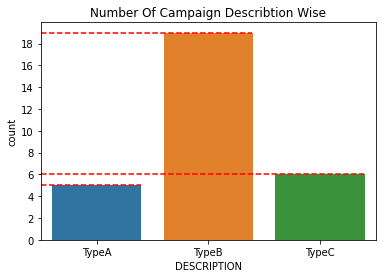

In [1096]:
## INSIGHT
# number of campaign Describtion wise.. plot
sns.countplot(campaign_desc.DESCRIPTION.sort_values())
plt.yticks(np.arange(0,20,2))
plt.title('number of campaign Describtion wise'.title())
plt.axhline(y=19,xmax=0.63,ls='--',color='red')
plt.axhline(y=6,xmax=0.965,ls='--',color='red')
plt.axhline(y=5,xmax=0.3,ls='--',color='red')
plt.show()

* Maximum no. of campaigns are of Type-B i.e. 19.

In [1097]:
campaign_desc.sort_values(['START_DAY','CAMPAIGN'])

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,DURATION
29,TypeA,26,224,264,40
28,TypeC,27,237,300,63
27,TypeB,28,259,320,61
26,TypeB,29,281,334,53
25,TypeA,30,323,369,46
23,TypeB,1,346,383,37
24,TypeB,2,351,383,32
20,TypeC,3,356,412,56
22,TypeB,4,372,404,32
21,TypeB,5,377,411,34


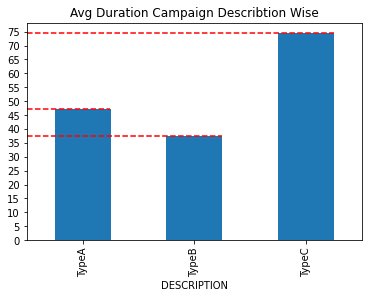

In [1098]:
## INSIGHT
# Avg duration campaign describtion wise.. plot.
campaign_desc.groupby('DESCRIPTION')['DURATION'].mean().plot(kind='bar')
plt.yticks(np.arange(0,80,5))
plt.axhline(y=47.2,ls='--',color='red',xmax=0.247)
plt.axhline(y=37.631579,ls='--',color='red',xmax=0.584)
plt.axhline(y=74.5,ls='--',color='red',xmax=0.916)
plt.title('Avg duration campaign describtion wise'.title())
plt.show()

* Type-C has the maximum avg duration of campaign.
* Type-B has the minimum avg duration of campaign.

## 2) Campaign table => campaign_table

* This table gives the detail of the type of campaign and the households/customers recieved a specific campaign.
* **Aim** - is to find the number of campaigns visited to each households.

In [1099]:
# No. of Campaigns recieved by each household...
# why we did this ?
# => we didnt have the exact count of no. of coupons recieved by each household.. So, we decided to fetch the 
#    information on the basis of campaign recieved per household to get a feature which might get handy 
#    while building model.
cnt_camp_recieved_per_hsld=pd.DataFrame(campaign_table.groupby('household_key')['CAMPAIGN'].count()).reset_index()
cnt_camp_recieved_per_hsld.rename(columns={'CAMPAIGN':'cnt_camp_recieved_per_hsld'},inplace=True)
cnt_camp_recieved_per_hsld.head(3)  # => Obtained from campaign_table.

,household_key,cnt_camp_recieved_per_hsld
0,1,8
1,2,1
2,3,3


In [1100]:
# As there are some household which recieved 0 campaigns, we need to get them as well.
temp=pd.DataFrame({'household_key':np.arange(1,2501)})
cnt_camp_recieved_per_hsld=pd.merge(temp,cnt_camp_recieved_per_hsld,on='household_key',how='left').fillna(0)
l.append('cnt_camp_recieved_per_hsld')
x.append(cnt_camp_recieved_per_hsld)
cnt_camp_recieved_per_hsld    # => Obtained from campaign_table.

,household_key,cnt_camp_recieved_per_hsld
0,1,8.0
1,2,1.0
2,3,3.0
3,4,1.0
4,5,0.0
...,...,...
2495,2496,5.0
2496,2497,3.0
2497,2498,6.0
2498,2499,2.0


## 3) Coupon redemption data =>  coupon_redempt
* This table provides with the details of the redemption of the coupon households campaign wise providing the day of redemption and coupon_upc.
* **Aim** - is to find the number of redemption per campaing by each customer/household.
    * Per campaign redemption count is considered as the number of coupon delieverd per household cannot be measured. 
* We will follow the below steps:
    * Household wise count of campaign for which at least one coupon has been redeemed.
    * Merge our campaign table, coupon redemption table and demographic table

In [1101]:
coupon_redempt.loc[:,['household_key','CAMPAIGN']]

,household_key,CAMPAIGN
0,1,8
1,1,8
2,1,8
3,1,18
4,1,18
...,...,...
2313,2496,18
2314,2496,18
2315,2500,8
2316,2500,8


In [1102]:
# Distinct campaign redempt by each household..
## no of coupon redemt on distinct campaigns by unique households.
## household wise count of campaigns in which the coupon were redempt
coupon_redempt_temp=coupon_redempt.loc[:,['household_key','CAMPAIGN']]
distinct_camprdmptn_per_hsld = pd.DataFrame(coupon_redempt_temp.drop_duplicates().groupby('household_key')['CAMPAIGN'].count()).reset_index().rename(columns={'CAMPAIGN':'distinct_camprdmptn_per_hsld'})
l.append('distinct_camprdmptn_per_hsld')
x.append(distinct_camprdmptn_per_hsld)
distinct_camprdmptn_per_hsld.head(3)     # => mined from coupon_redempt

,household_key,distinct_camprdmptn_per_hsld
0,1,2
1,8,1
2,13,7


In [1103]:
## INSIGHT
# Number of campaign recieved by number of households...
cnt_of_camp_recieved_by_num_of_hsld=cnt_camp_recieved_per_hsld.groupby('cnt_camp_recieved_per_hsld').count().reset_index().rename(columns={'household_key':'cnt_household_key'})
l.append('cnt_of_camp_recieved_by_num_of_hsld')
cnt_of_camp_recieved_by_num_of_hsld

,cnt_camp_recieved_per_hsld,cnt_household_key
0,0.0,916
1,1.0,268
2,2.0,224
3,3.0,214
4,4.0,169
5,5.0,179
6,6.0,138
7,7.0,120
8,8.0,94
9,9.0,62


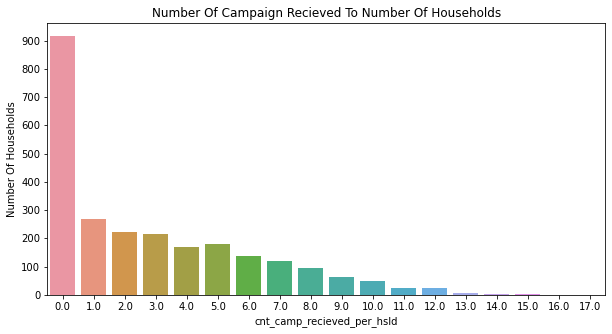

In [1104]:
## INSIGHT
# Plotting Number of campaign recieved by number of households
plt.figure(figsize=(10,5))
sns.countplot(cnt_camp_recieved_per_hsld.cnt_camp_recieved_per_hsld)
plt.title('number of campaign recieved to number of households'.title())
plt.ylabel('number of households'.title())
plt.yticks(np.arange(0,1000,100))
plt.show()

In [1105]:
distinct_camprdmptn_per_hsld

,household_key,distinct_camprdmptn_per_hsld
0,1,2
1,8,1
2,13,7
3,14,1
4,18,3
...,...,...
429,2488,5
430,2489,6
431,2494,1
432,2496,3


In [1106]:
## INSIGHT
# Redemption_Rate of coupon campaign wise...  => MOST IMP (personally)
camp_rdmptn_rate=pd.merge(cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,on='household_key',how='outer').fillna(0)
camp_rdmptn_rate['camp_rdmptn_rate']=camp_rdmptn_rate['distinct_camprdmptn_per_hsld']/camp_rdmptn_rate['cnt_camp_recieved_per_hsld']
#camp_rdmptn_rate.sort_values('camp_rdmptn_rate',ascending=False).head(20)
l.append('camp_rdmptn_rate')
camp_rdmptn_rate.sort_values(['camp_rdmptn_rate','cnt_camp_recieved_per_hsld'],ascending=False).head(30)

# demographic information of the households were the redemption rate was maximum can be studied.
# And the households with the similar pattern 


## Coupon redemption rate is the ratio of no. of campaigns received and coupon redemption on those campaigns.

,household_key,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate
366,367,9.0,9.0,1.000000
1590,1591,4.0,4.0,1.000000
425,426,3.0,3.0,1.000000
1317,1318,3.0,3.0,1.000000
1989,1990,3.0,3.0,1.000000
138,139,2.0,2.0,1.000000
1920,1921,2.0,2.0,1.000000
2374,2375,2.0,2.0,1.000000
78,79,1.0,1.0,1.000000
214,215,1.0,1.0,1.000000


In [1107]:
camp_rdmptn_rate.sort_values(['cnt_camp_recieved_per_hsld','camp_rdmptn_rate'],ascending=False).head(3)

,household_key,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate
2316,2317,17.0,3.0,0.176471
2488,2489,16.0,6.0,0.375000
717,718,15.0,5.0,0.333333


In [1108]:
camp_rdmptn_rate.fillna(0,inplace=True)

In [1109]:
#x.append(camp_rdmptn_rate)
x.append(camp_rdmptn_rate.loc[:,['household_key','camp_rdmptn_rate']])

In [1110]:
# Coupon redemption campaign wise..
cpnrdmpt_campwise=pd.merge(campaign_desc.loc[:,['DESCRIPTION','CAMPAIGN']],coupon_redempt.loc[:,['household_key','CAMPAIGN']],on='CAMPAIGN')
l.append('cpnrdmpt_campwise')

In [1111]:
## INSIGHT
# Effeciancy campaign type wise..
cpnrdmpt_campwise.groupby('DESCRIPTION')['household_key'].count()

DESCRIPTION
TypeA    1791
TypeB     454
TypeC      73
Name: household_key, dtype: int64

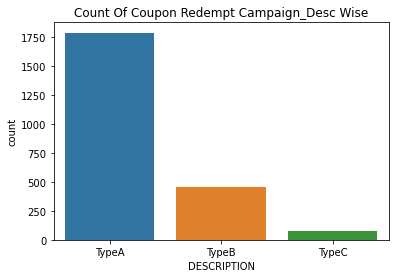

In [1112]:
## INSIGHT
# Count of coupon redempt campaign_desc wise
sns.countplot(cpnrdmpt_campwise.DESCRIPTION.sort_values())
plt.title('Count of coupon redempt campaign_desc wise'.title())
plt.show()

* Promotional activity was best for TypeA campaigns
* and worst for TypeC

In [1113]:
print('Best performing campaigns :',sorted(campaign_desc.loc[campaign_desc.DESCRIPTION=='TypeA','CAMPAIGN']))
print('Worst performing campaigns :',sorted(campaign_desc.loc[campaign_desc.DESCRIPTION=='TypeC','CAMPAIGN']))

Best performing campaigns : [8, 13, 18, 26, 30]
Worst performing campaigns : [3, 6, 14, 15, 20, 27]


## 4) Customers details => hh_demographic table

In [1114]:
# basic cleaning of the demographic data => hh_demographic
hh_demographic['MARITAL_STATUS_CODE']=hh_demographic.MARITAL_STATUS_CODE.map({'A':'Married','B':'Single','U':'Unknown'})
hh_demographic['KID_CATEGORY_DESC']=np.where(hh_demographic.KID_CATEGORY_DESC=='None/Unknown',0,hh_demographic.KID_CATEGORY_DESC)
hh_demographic['KID_CATEGORY_DESC']=np.where(hh_demographic.KID_CATEGORY_DESC=='3+',3,hh_demographic.KID_CATEGORY_DESC)
hh_demographic['HOUSEHOLD_SIZE_DESC']=np.where(hh_demographic.HOUSEHOLD_SIZE_DESC=='5+',5,hh_demographic.HOUSEHOLD_SIZE_DESC)
hh_demographic

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,Target
0,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0,1,1
1,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,0,7,0
2,25-34,Unknown,25-34K,Unknown,2 Adults Kids,3,1,8,1
3,25-34,Unknown,75-99K,Homeowner,2 Adults Kids,4,2,13,1
4,45-54,Single,50-74K,Homeowner,Single Female,1,0,16,0
...,...,...,...,...,...,...,...,...,...
796,35-44,Unknown,50-74K,Homeowner,2 Adults No Kids,2,0,2494,1
797,45-54,Married,75-99K,Homeowner,Unknown,3,1,2496,1
798,45-54,Unknown,35-49K,Unknown,Single Male,1,0,2497,0
799,25-34,Unknown,50-74K,Homeowner,2 Adults No Kids,2,0,2498,0


* Out of 2500 households (from transaction data), demographic information of only 801 households are known.
* Out of 801 only 760 households were targeted by the campaigns.

 ## 5) Transactioin Data => transaction_data table
This table contains the transaction of past 2 years of 2500 households. But we need to clean the data as we are excluding last 3 campaigns.


To clean the dataset, we will follow the below steps :

* Load the data
* Keep sales before day 645
* Exclude transaction with sales value and quantity inferior or equal to 0 

In [1115]:
transaction_data[transaction_data.SALES_VALUE==0].shape

(18850, 12)

In [1116]:
transaction_data[transaction_data.QUANTITY==0].shape

(14466, 12)

In [1117]:
# these trasnsactions is to be removed from the dataset
transaction_data=transaction_data.loc[(transaction_data.SALES_VALUE>0)&(transaction_data.QUANTITY>0),:]

In [1118]:
# total sales per customer.
hsld_wise_ttlsales=transaction_data.groupby('household_key').agg(TOTAL_SALES_VALUE_hsld_wise=('SALES_VALUE','sum')).reset_index()
l.append('hsld_wise_ttlsales')
x.append(hsld_wise_ttlsales)
hsld_wise_ttlsales.head(3)   # => obtained from transaction

,household_key,TOTAL_SALES_VALUE_hsld_wise
0,1,4330.16
1,2,1954.34
2,3,2653.21


In [1119]:
# No. of products purchased in a single visit.
No_of_items_in_single_trans=transaction_data.groupby(['household_key','BASKET_ID','DAY'])['QUANTITY'].sum().reset_index().rename(columns={'QUANTITY':'No_of_items_in_single_trans'})
l.append('No_of_items_in_single_trans')
No_of_items_in_single_trans

,household_key,BASKET_ID,DAY,No_of_items_in_single_trans
0,1,27601281299,51,34
1,1,27774192959,67,14
2,1,28024266849,88,13
3,1,28106322445,94,32
4,1,28235481967,101,20
...,...,...,...,...
275534,2500,42076591137,695,2
275535,2500,42115225458,698,12
275536,2500,42198526427,704,31
275537,2500,42229520973,706,6


In [1120]:
# Mean items purchased per transaction by specific households.
mean_items_purch_per_trans=No_of_items_in_single_trans.loc[:,['household_key','No_of_items_in_single_trans']]
mean_items_purch_per_trans=mean_items_purch_per_trans.groupby('household_key')['No_of_items_in_single_trans'].mean().reset_index().rename(columns={'No_of_items_in_single_trans':'mean_items_purch_per_trans'})
#Avg_items_purch_per_trans.drop_duplicates(inplace=True)
mean_items_purch_per_trans=mean_items_purch_per_trans.round()
l.append('mean_items_purch_per_trans')
x.append(mean_items_purch_per_trans)
mean_items_purch_per_trans.head(3)# => obtained from No_of_items_in_single_trans
## average numbers of itmes purchased in a single transaction]

,household_key,mean_items_purch_per_trans
0,1,23.0
1,2,19.0
2,3,182.0


In [1121]:
# Total number of visits per customer
No_of_total_visits=pd.DataFrame(No_of_items_in_single_trans.groupby('household_key').size(),columns=['No_of_total_visits']).reset_index()
l.append('No_of_total_visits')
x.append(No_of_total_visits)
No_of_total_visits.head(3)

# Total number of visits made by unique households over the span of two years.

,household_key,No_of_total_visits
0,1,85
1,2,45
2,3,47


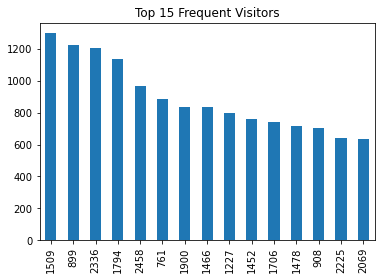

In [1122]:
## INSIGHT
No_of_total_visits.sort_values('No_of_total_visits',ascending=False)[:15]['No_of_total_visits'].plot(kind='bar')
plt.title('Top 15 frequent visitors'.title())
plt.show()

In [1123]:
# Amount spent by each customer in single transaction on the particular day. 
amt_spent_single_trans = pd.DataFrame(transaction_data.groupby(['household_key','BASKET_ID','DAY'])['SALES_VALUE'].sum()).reset_index()
l.append('amt_spent_single_trans')
amt_spent_single_trans

,household_key,BASKET_ID,DAY,SALES_VALUE
0,1,27601281299,51,78.66
1,1,27774192959,67,41.10
2,1,28024266849,88,26.90
3,1,28106322445,94,63.43
4,1,28235481967,101,53.45
...,...,...,...,...
275534,2500,42076591137,695,4.00
275535,2500,42115225458,698,50.54
275536,2500,42198526427,704,73.65
275537,2500,42229520973,706,13.95


In [1124]:
# Mean amount spent by specific househlds per transaction wise.
mean_spent_single_trans_hsldwise=amt_spent_single_trans.loc[:,['household_key','SALES_VALUE']].groupby('household_key')['SALES_VALUE'].mean().reset_index().rename(columns={'SALES_VALUE':'MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'})
mean_spent_single_trans_hsldwise=mean_spent_single_trans_hsldwise.round(2)
l.append('mean_spent_single_trans_hsldwise')
x.append(mean_spent_single_trans_hsldwise)
mean_spent_single_trans_hsldwise.head(3)

## Avearge purchase made by unique households in a single transaction
 

,household_key,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS
0,1,50.94
1,2,43.43
2,3,56.45


In [1125]:
# Median amount spent by specific househlds per transaction wise => No impact of outliers..
median_spent_single_trans_hsldwise = pd.DataFrame(amt_spent_single_trans.groupby('household_key')['SALES_VALUE'].median()).reset_index().rename(columns={'SALES_VALUE':'MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'})
l.append('median_spent_single_trans_hsldwise')
median_spent_single_trans_hsldwise=median_spent_single_trans_hsldwise.round(2)
x.append(median_spent_single_trans_hsldwise)
median_spent_single_trans_hsldwise.head(3)

,household_key,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS
0,1,49.33
1,2,26.94
2,3,36.38


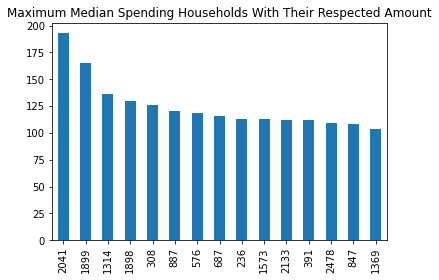

In [1126]:
## INSIGHT
# Maximum spending households with the amount they spend.
median_spent_single_trans_hsldwise.sort_values('MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS',ascending=False)[:15]['MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'].plot(kind='bar')
plt.title('Maximum median spending households with their respected amount'.title())
plt.show()

In [1127]:
# mean product cost household wise 
avg_productcst_purchased_hsldwise=pd.DataFrame({'household_key':transaction_data.household_key,'Price_per_product_purchased':transaction_data.SALES_VALUE/transaction_data.QUANTITY}).groupby('household_key')['Price_per_product_purchased'].mean().reset_index()
l.append('avg_productcst_purchased_hsldwise')
avg_productcst_purchased_hsldwise=avg_productcst_purchased_hsldwise.round(2)
x.append(avg_productcst_purchased_hsldwise)
avg_productcst_purchased_hsldwise.head(3)

## it is the average price of product generally purchased by unique households.

,household_key,Price_per_product_purchased
0,1,2.31
1,2,2.53
2,3,1.98


In [1128]:
l

['cnt_camp_recieved_per_hsld',
 'distinct_camprdmptn_per_hsld',
 'cnt_of_camp_recieved_by_num_of_hsld',
 'camp_rdmptn_rate',
 'cpnrdmpt_campwise',
 'hsld_wise_ttlsales',
 'No_of_items_in_single_trans',
 'mean_items_purch_per_trans',
 'No_of_total_visits',
 'amt_spent_single_trans',
 'mean_spent_single_trans_hsldwise',
 'median_spent_single_trans_hsldwise',
 'avg_productcst_purchased_hsldwise']

In [1129]:
a=['count of campaign recieved per household',
   'coupons of distinct campaign redempt by specific household',
  'number of campaign recieved by number of households',
   'rate of redemption of each household',
   'Coupon redemption campaign wise',
   'total purchase done by each household during tha span of 2 years',
  'total number of transactions and number of product purchased per transaction',
   'average number of products purchased per transaction wise',
   'total number of visits of each households',
  'amount spent in a single transaction',
   'mean spent of each household in single transaction',
   'median spent of each household in single transaction',
  'average cost of products purchased by specific household']
Extracted_tables_info=pd.DataFrame({'Tables Extracted':l,'Information Derived':a})
Extracted_tables_info

,Tables Extracted,Information Derived
0,cnt_camp_recieved_per_hsld,count of campaign recieved per household
1,distinct_camprdmptn_per_hsld,coupons of distinct campaign redempt by specif...
2,cnt_of_camp_recieved_by_num_of_hsld,number of campaign recieved by number of house...
3,camp_rdmptn_rate,rate of redemption of each household
4,cpnrdmpt_campwise,Coupon redemption campaign wise
5,hsld_wise_ttlsales,total purchase done by each household during t...
6,No_of_items_in_single_trans,total number of transactions and number of pro...
7,mean_items_purch_per_trans,average number of products purchased per trans...
8,No_of_total_visits,total number of visits of each households
9,amt_spent_single_trans,amount spent in a single transaction


In [1130]:
# Merging of all the features obtained during feature engineering to the obtain the main file for modeling.
d=hh_demographic.copy()
for i in x:
    d=pd.merge(d,i,on='household_key',how='left')
d.set_index('household_key',inplace=True)
d

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Target,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,,
1,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0,1,8.0,2.0,0.25,4330.16,23.0,85,50.94,49.33,2.31
7,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,0,0,4.0,NaN,0.00,3400.05,26.0,59,57.63,47.97,2.40
8,25-34,Unknown,25-34K,Unknown,2 Adults Kids,3,1,1,10.0,1.0,0.10,5534.97,605.0,113,48.98,35.80,2.40
13,25-34,Unknown,75-99K,Homeowner,2 Adults Kids,4,2,1,10.0,7.0,0.70,13190.92,6778.0,275,47.97,40.96,2.93
16,45-54,Single,50-74K,Homeowner,Single Female,1,0,0,2.0,NaN,0.00,1512.02,829.0,98,15.43,12.68,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,35-44,Unknown,50-74K,Homeowner,2 Adults No Kids,2,0,1,2.0,1.0,0.50,2120.93,1653.0,35,60.60,50.57,2.73
2496,45-54,Married,75-99K,Homeowner,Unknown,3,1,1,5.0,3.0,0.60,4339.66,2068.0,63,68.88,73.52,2.24
2497,45-54,Unknown,35-49K,Unknown,Single Male,1,0,0,3.0,NaN,0.00,7111.98,277.0,221,32.18,18.12,2.83


In [1131]:
d.isnull().sum()
# distinct_camprdmptn_per_hsld => nan values represent those households which redempt 0 coupons from distant campaign.

AGE_DESC                                         0
MARITAL_STATUS_CODE                              0
INCOME_DESC                                      0
HOMEOWNER_DESC                                   0
HH_COMP_DESC                                     0
HOUSEHOLD_SIZE_DESC                              0
KID_CATEGORY_DESC                                0
Target                                           0
cnt_camp_recieved_per_hsld                       0
distinct_camprdmptn_per_hsld                   490
camp_rdmptn_rate                                 0
TOTAL_SALES_VALUE_hsld_wise                      0
mean_items_purch_per_trans                       0
No_of_total_visits                               0
MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS        0
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS      0
Price_per_product_purchased                      0
dtype: int64

In [1132]:
d.fillna(0,inplace=True)

In [1133]:
# Triming will be done as the data contains those households who didnt recieved coupons from any of a campaign.
d=d[d.cnt_camp_recieved_per_hsld!=0]

In [1134]:
d.shape

(760, 17)

In [1135]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 1 to 2499
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   AGE_DESC                                     760 non-null    object 
 1   MARITAL_STATUS_CODE                          760 non-null    object 
 2   INCOME_DESC                                  760 non-null    object 
 3   HOMEOWNER_DESC                               760 non-null    object 
 4   HH_COMP_DESC                                 760 non-null    object 
 5   HOUSEHOLD_SIZE_DESC                          760 non-null    object 
 6   KID_CATEGORY_DESC                            760 non-null    object 
 7   Target                                       760 non-null    int64  
 8   cnt_camp_recieved_per_hsld                   760 non-null    float64
 9   distinct_camprdmptn_per_hsld                 760 non-null    float64
 10  c

### Statistical test

In [1136]:
pd.DataFrame(stats.f_oneway(d['cnt_camp_recieved_per_hsld'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of cnt_camp_recieved_per_hsld'])

,F_onewayresult of cnt_camp_recieved_per_hsld
Test_Statistics,2.112970e+03
pvalue,9.050725e-290


In [1137]:
9.050725e-290<0.5

True

In [1138]:
pd.DataFrame(stats.f_oneway(d['distinct_camprdmptn_per_hsld'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of distinct_camprdmptn_per_hsld'])

,F_onewayresult of distinct_camprdmptn_per_hsld
Test_Statistics,7.039228e+01
pvalue,1.097288e-16


In [1139]:
1.097288e-16<0.5

True

In [1140]:
pd.DataFrame(stats.f_oneway(d['camp_rdmptn_rate'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of camp_rdmptn_rate'])

,F_onewayresult of camp_rdmptn_rate
Test_Statistics,1.750850e+02
pvalue,6.600895e-38


In [1141]:
6.600895e-38<0.5

True

In [1142]:
pd.DataFrame(stats.f_oneway(d['TOTAL_SALES_VALUE_hsld_wise'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of TOTAL_SALES_VALUE_hsld_wise'])

,F_onewayresult of TOTAL_SALES_VALUE_hsld_wise
Test_Statistics,1.797826e+03
pvalue,7.944291e-260


In [1143]:
7.944291e-260<0.5

True

In [1144]:
pd.DataFrame(stats.f_oneway(d['mean_items_purch_per_trans'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of mean_items_purch_per_trans'])

,F_onewayresult of mean_items_purch_per_trans
Test_Statistics,4.597601e+02
pvalue,2.609885e-89


In [1145]:
2.609885e-89<0.5

True

In [1146]:
pd.DataFrame(stats.f_oneway(d['No_of_total_visits'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of No_of_total_visits'])

,F_onewayresult of No_of_total_visits
Test_Statistics,1.403534e+03
pvalue,4.536211e-218


In [1147]:
4.536211e-218<0.5

True

In [1148]:
pd.DataFrame(stats.f_oneway(d['MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'])

,F_onewayresult of MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS
Test_Statistics,2.324380e+03
pvalue,1.967052e-308


In [1149]:
1.967052e-308<0.5

True

In [1150]:
pd.DataFrame(stats.f_oneway(d['MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult'])

,F_onewayresult
Test_Statistics,1.598726e+03
pvalue,2.108284e-239


In [1151]:
2.108284e-239<0.5

True

In [1152]:
pd.DataFrame(stats.f_oneway(d['Price_per_product_purchased'],d['Target']),index=['Test_Statistics','pvalue'],columns=['F_onewayresult of Price_per_product_purchased'])

,F_onewayresult of Price_per_product_purchased
Test_Statistics,6913.179884
pvalue,0.000000


## Univariate Analysis

In [1153]:
numcol=d.select_dtypes(np.number).columns
catcol=d.select_dtypes('object').columns

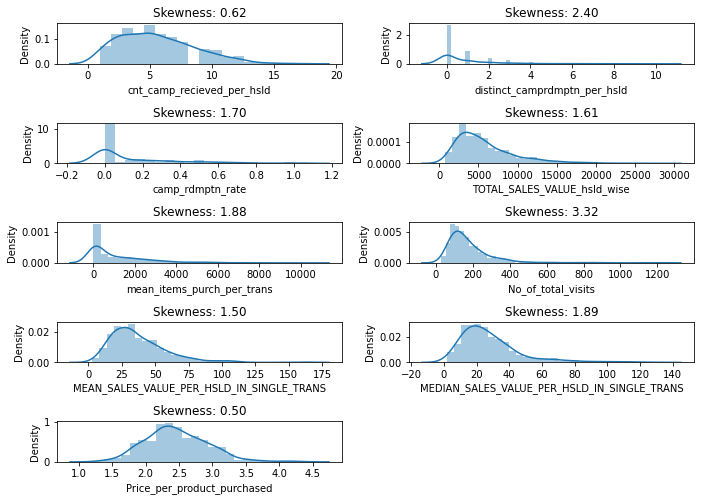

In [1154]:
plt.figure(figsize=(10,8))
ii=1
for i in numcol[1:]:
    plt.subplot(len(numcol)//2+1,2,ii)
    sns.distplot(d[i])
    plt.title('Skewness: %0.2f'%(d[i].skew()))
    ii+=1
plt.tight_layout()    
plt.show()

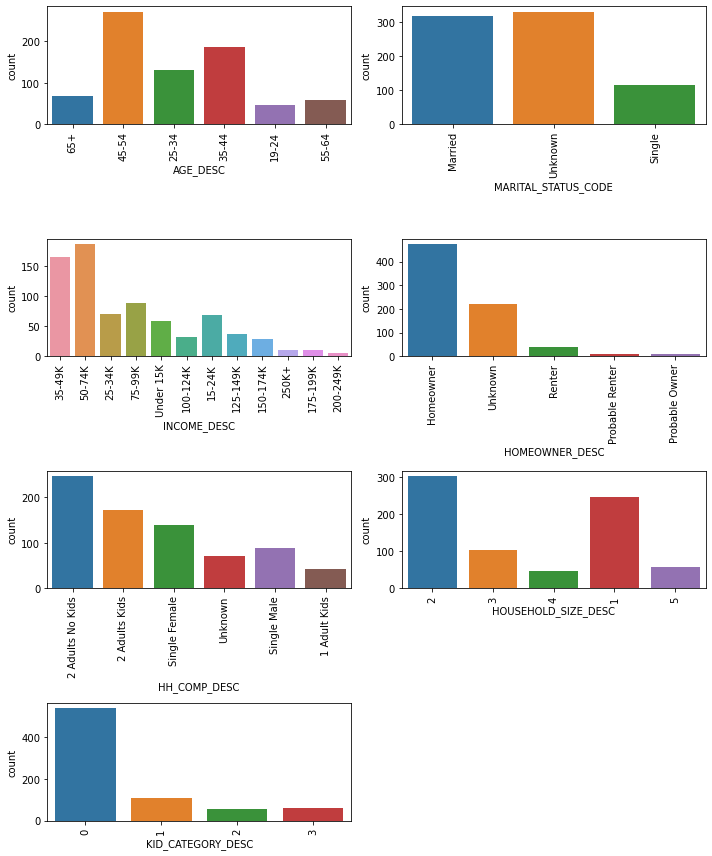

In [1155]:
plt.figure(figsize=(10,12))
ii=1
for i in catcol:
    plt.subplot(len(catcol)//2+1,2,ii)
    sns.countplot(d[i])
    plt.xticks(rotation=90)
    ii+=1
plt.tight_layout()
plt.show()

# Bivariate Analysis

In [1156]:
catcol

Index(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC',
       'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'],
      dtype='object')

In [1157]:
d

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Target,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,,
1,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0,1,8.0,2.0,0.25,4330.16,23.0,85,50.94,49.33,2.31
7,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,0,0,4.0,0.0,0.00,3400.05,26.0,59,57.63,47.97,2.40
8,25-34,Unknown,25-34K,Unknown,2 Adults Kids,3,1,1,10.0,1.0,0.10,5534.97,605.0,113,48.98,35.80,2.40
13,25-34,Unknown,75-99K,Homeowner,2 Adults Kids,4,2,1,10.0,7.0,0.70,13190.92,6778.0,275,47.97,40.96,2.93
16,45-54,Single,50-74K,Homeowner,Single Female,1,0,0,2.0,0.0,0.00,1512.02,829.0,98,15.43,12.68,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,35-44,Unknown,50-74K,Homeowner,2 Adults No Kids,2,0,1,2.0,1.0,0.50,2120.93,1653.0,35,60.60,50.57,2.73
2496,45-54,Married,75-99K,Homeowner,Unknown,3,1,1,5.0,3.0,0.60,4339.66,2068.0,63,68.88,73.52,2.24
2497,45-54,Unknown,35-49K,Unknown,Single Male,1,0,0,3.0,0.0,0.00,7111.98,277.0,221,32.18,18.12,2.83


<Figure size 720x864 with 0 Axes>

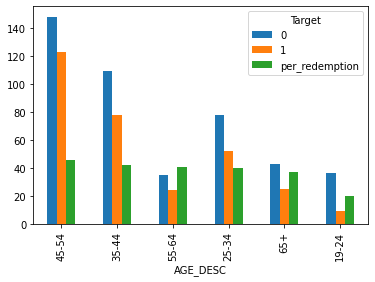

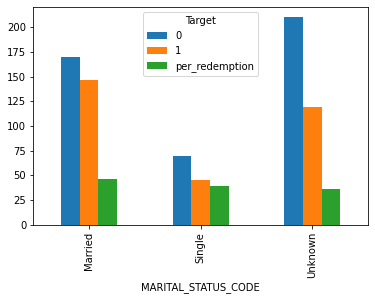

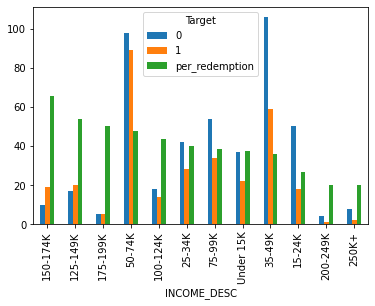

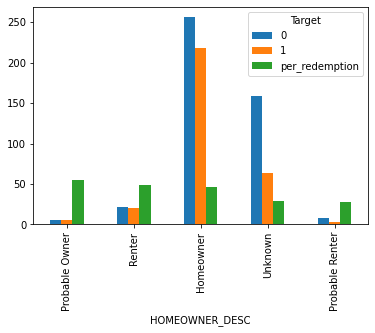

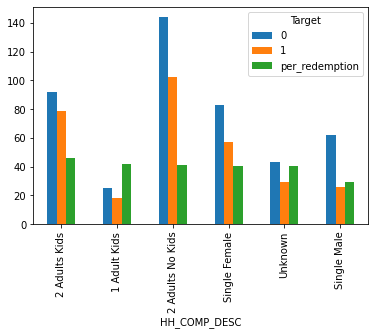

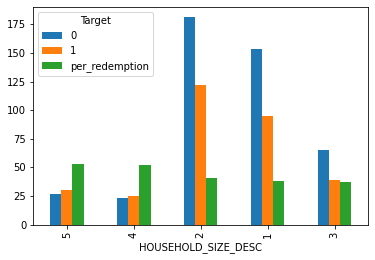

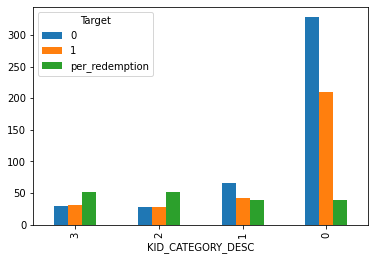

In [1158]:
plt.figure(figsize=(10,12))
ii=1
for i in catcol:
    a=pd.crosstab(d[i],d.Target)
    a['per_redemption']=a[1]/(a[0]+a[1])*100
    a.sort_values('per_redemption',ascending=False).plot(kind='bar')
    plt.show()

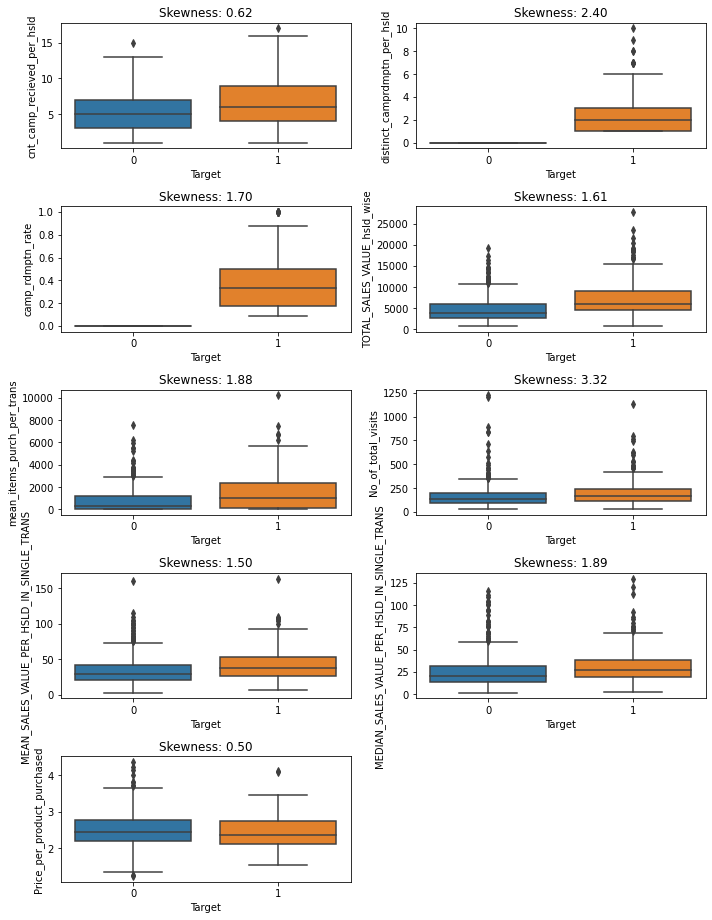

In [1159]:
plt.figure(figsize=(10,15))
ii=1
for i in numcol[1:]:
    plt.subplot(len(numcol)//2+1,2,ii)
    sns.boxplot(d['Target'],d[i])
    plt.title('Skewness: %0.2f'%(d[i].skew()))
    ii=ii+1
plt.tight_layout()
plt.show()

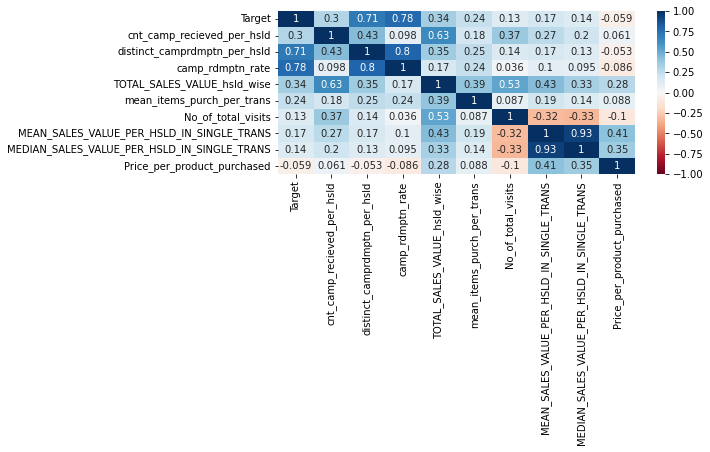

In [1160]:
# correlation plot before encoding and scalling..
plt.figure(figsize=(8,3))
sns.heatmap(d.corr(),annot=True,vmin=-1,vmax=+1,cmap='RdBu')
plt.show()

# Outliers Treatement

In [1161]:
d.describe().T


,count,mean,std,min,25%,50%,75%,max
Target,760.0,0.409211,0.492012,0.00,0.000,0.000,1.0000,1.00
cnt_camp_recieved_per_hsld,760.0,5.543421,3.039608,1.00,3.000,5.000,7.2500,17.00
distinct_camprdmptn_per_hsld,760.0,0.892105,1.508497,0.00,0.000,0.000,1.0000,10.00
camp_rdmptn_rate,760.0,0.148559,0.229849,0.00,0.000,0.000,0.2500,1.00
TOTAL_SALES_VALUE_hsld_wise,760.0,5775.177724,3754.633354,760.45,3080.465,4838.825,7278.3000,27859.68
mean_items_purch_per_trans,760.0,1100.185526,1413.987268,3.00,34.750,475.500,1708.2500,10234.00
No_of_total_visits,760.0,179.032895,131.441146,28.00,101.000,144.500,216.0000,1223.00
MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,760.0,37.190316,21.026119,2.84,22.080,32.545,47.2700,163.43
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,760.0,27.975092,18.999671,1.52,15.150,23.690,34.9425,129.83
Price_per_product_purchased,760.0,2.462039,0.470321,1.24,2.160,2.420,2.7700,4.37


In [1162]:
d.skew()

HOUSEHOLD_SIZE_DESC                            1.052224
KID_CATEGORY_DESC                              1.671241
Target                                         0.370028
cnt_camp_recieved_per_hsld                     0.615574
distinct_camprdmptn_per_hsld                   2.402883
camp_rdmptn_rate                               1.695531
TOTAL_SALES_VALUE_hsld_wise                    1.609645
mean_items_purch_per_trans                     1.877262
No_of_total_visits                             3.315898
MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS      1.500938
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS    1.893073
Price_per_product_purchased                    0.504584
dtype: float64

In [1163]:
# caping of outiers is done.
for i in numcol:
    q1 = d[i].quantile(0.25)
    q3 = d[i].quantile(0.75)
    iqr = q3-q1
    ul = q3+1.5*iqr
    ll = q1-1.5*iqr
    d.loc[d[i]>ul,i] =ul
    d.loc[d[i]<ll,i] =ll

In [1164]:
d.describe()

,Target,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,0.409211,5.530757,0.678947,0.138921,5623.909217,1044.481579,168.929605,36.560875,26.864638,2.457770
std,0.492012,3.001019,0.919460,0.201992,3285.386668,1231.175780,91.351036,18.913709,15.476639,0.456839
min,0.000000,1.000000,0.000000,0.000000,760.450000,3.000000,28.000000,2.840000,1.520000,1.245000
25%,0.000000,3.000000,0.000000,0.000000,3080.465000,34.750000,101.000000,22.080000,15.150000,2.160000
50%,0.000000,5.000000,0.000000,0.000000,4838.825000,475.500000,144.500000,32.545000,23.690000,2.420000
75%,1.000000,7.250000,1.000000,0.250000,7278.300000,1708.250000,216.000000,47.270000,34.942500,2.770000
max,1.000000,13.625000,2.500000,0.625000,13575.052500,4218.500000,388.500000,85.055000,64.631250,3.685000


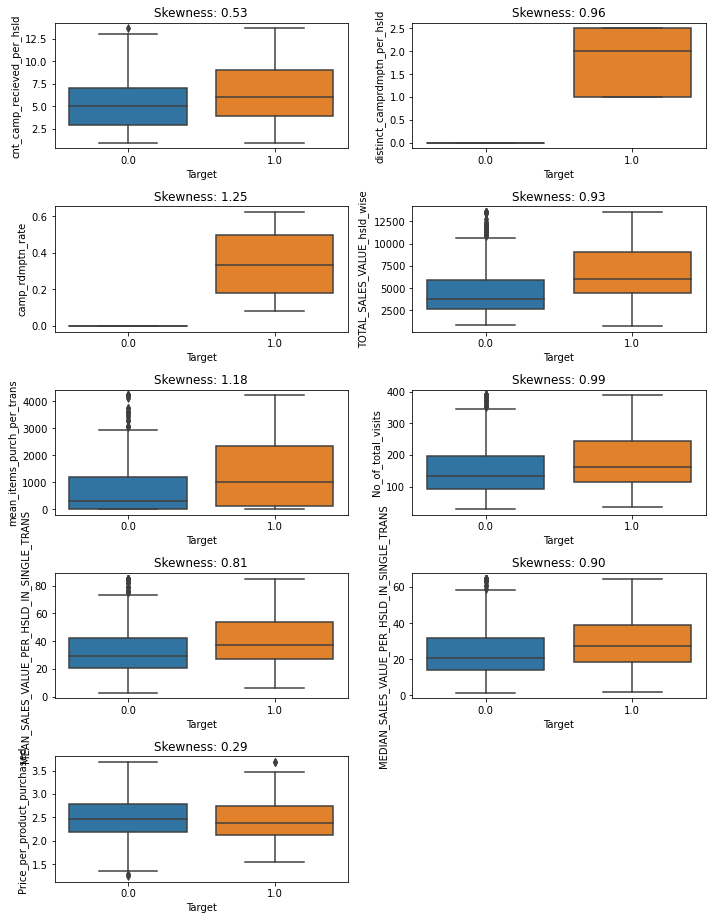

In [1165]:
plt.figure(figsize=(10,15))
ii=1
for i in numcol[1:]:
    plt.subplot(len(numcol)//2+1,2,ii)
    sns.boxplot(d['Target'],d[i])
    plt.title('Skewness: %0.2f'%(d[i].skew()))
    ii=ii+1
plt.tight_layout()
plt.show()

In [1166]:
d.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Target,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,,
1,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0,1.0,8.0,2.0,0.25,4330.16,23.0,85.0,50.94,49.33,2.31
7,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,0,0.0,4.0,0.0,0.00,3400.05,26.0,59.0,57.63,47.97,2.40


In [1167]:
df1=d.copy()

In [1168]:
df1.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Target,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,,
1,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0,1.0,8.0,2.0,0.250,4330.16,23.0,85.0,50.94,49.33,2.31
7,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,0,0.0,4.0,0.0,0.000,3400.05,26.0,59.0,57.63,47.97,2.40
8,25-34,Unknown,25-34K,Unknown,2 Adults Kids,3,1,1.0,10.0,1.0,0.100,5534.97,605.0,113.0,48.98,35.80,2.40
13,25-34,Unknown,75-99K,Homeowner,2 Adults Kids,4,2,1.0,10.0,2.5,0.625,13190.92,4218.5,275.0,47.97,40.96,2.93
16,45-54,Single,50-74K,Homeowner,Single Female,1,0,0.0,2.0,0.0,0.000,1512.02,829.0,98.0,15.43,12.68,2.38


In [1169]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 1 to 2499
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   AGE_DESC                                     760 non-null    object 
 1   MARITAL_STATUS_CODE                          760 non-null    object 
 2   INCOME_DESC                                  760 non-null    object 
 3   HOMEOWNER_DESC                               760 non-null    object 
 4   HH_COMP_DESC                                 760 non-null    object 
 5   HOUSEHOLD_SIZE_DESC                          760 non-null    object 
 6   KID_CATEGORY_DESC                            760 non-null    object 
 7   Target                                       760 non-null    float64
 8   cnt_camp_recieved_per_hsld                   760 non-null    float64
 9   distinct_camprdmptn_per_hsld                 760 non-null    float64
 10  c

### splitting into train and test

In [1219]:
X = df1.drop('Target',axis=1)
y= df1['Target']

In [1220]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.20,stratify=y)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((608, 16), (608,), (152, 16), (152,))

## Scaling

In [1221]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
for i in df1.select_dtypes(np.number).columns[1:]:
    xtrain[i]=sc.fit_transform(xtrain[[i]])
    xtest[i]=sc.transform(xtest[[i]])

In [1222]:
xtest

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,
1899,25-34,Married,25-34K,Homeowner,2 Adults Kids,3,1,2.204822,1.484390,0.143189,1.704803,-0.674968,-1.090017,2.560014,2.458768,1.222778
52,45-54,Single,50-74K,Homeowner,2 Adults No Kids,2,0,0.183539,-0.735805,-0.685319,-0.031720,0.329678,-0.330714,0.167829,-0.333474,0.477092
1020,45-54,Married,25-34K,Homeowner,2 Adults No Kids,2,0,-0.153342,0.374293,0.308890,1.190300,-0.630658,0.016396,1.030223,0.541952,0.455787
586,19-24,Married,35-49K,Renter,2 Adults Kids,3,1,0.857300,-0.735805,-0.685319,0.068869,0.067036,0.450283,-0.455740,-0.692457,-0.162068
1167,35-44,Unknown,50-74K,Homeowner,2 Adults Kids,4,2,1.194180,0.374293,-0.132980,0.361658,0.543176,-0.211395,0.474889,0.673493,0.754061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317,35-44,Married,50-74K,Homeowner,2 Adults Kids,5,3,2.752253,2.039439,0.191925,2.394147,0.684970,-0.211395,2.560014,2.458768,-0.481647
1018,45-54,Married,35-49K,Homeowner,2 Adults Kids,5,3,-0.153342,-0.735805,-0.685319,-1.036135,-0.654022,-0.037840,-1.228378,-1.286010,0.796672
443,45-54,Married,25-34K,Homeowner,2 Adults No Kids,2,0,-0.490222,0.374293,0.557443,-0.884478,-0.824819,-0.742907,-0.530275,-0.446223,-0.929059


## Encoding

In [1223]:
### Frequency Encoding on Age DESc

dic1 =  xtrain.AGE_DESC.value_counts(normalize=True).to_dict()
dic2 =  xtest.AGE_DESC.value_counts(normalize=True).to_dict()


In [1224]:
xtrain.AGE_DESC = xtrain.AGE_DESC.map(dic1)
xtest.AGE_DESC = xtest.AGE_DESC.map(dic2)


In [1225]:
xtrain.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,
886,0.248355,Married,100-124K,Homeowner,2 Adults No Kids,2,0,-0.827103,-0.735805,-0.685319,-0.210837,0.535119,0.309270,-0.607958,-0.433263,1.329305
2185,0.159539,Unknown,125-149K,Homeowner,2 Adults Kids,4,2,2.204822,0.374293,-0.271065,0.887139,0.881549,-0.699518,2.370266,1.535311,1.435832


In [1226]:
xtest.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,
1899,0.217105,Married,25-34K,Homeowner,2 Adults Kids,3,1,2.204822,1.484390,0.143189,1.704803,-0.674968,-1.090017,2.560014,2.458768,1.222778
52,0.355263,Single,50-74K,Homeowner,2 Adults No Kids,2,0,0.183539,-0.735805,-0.685319,-0.031720,0.329678,-0.330714,0.167829,-0.333474,0.477092


In [1227]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [1228]:
xtrain['MARITAL_STATUS_CODE'] = le.fit_transform(xtrain['MARITAL_STATUS_CODE'])

In [1229]:
xtest['MARITAL_STATUS_CODE'] = le.transform(xtest['MARITAL_STATUS_CODE'])

In [1230]:
di = {'Under 15K':0,'15-24K':1,'25-34K':2,'35-49K':3,'50-74K':4,'75-99K':5,'100-124K':6,'125-149K':7,'150-174K':8,
      '175-199K':9,'200-249K':10,'250K+':11}

In [1231]:
xtrain['INCOME_DESC'] = xtrain['INCOME_DESC'].map(di)
xtest['INCOME_DESC'] = xtest['INCOME_DESC'].map(di)

In [1232]:
xtrain['HOMEOWNER_DESC'] = xtrain['HOMEOWNER_DESC'].replace(['Homeowner','Unknown','Probable Renter','Probable Owner'],
                                                        ['Owner','Others','Renter','Owner'])

xtest['HOMEOWNER_DESC'] = xtest['HOMEOWNER_DESC'].replace(['Homeowner','Unknown','Probable Renter','Probable Owner'],
                                                        ['Owner','Others','Renter','Owner'])

In [1233]:
lr = LabelEncoder()
xtrain['HOMEOWNER_DESC'] = lr.fit_transform(xtrain['HOMEOWNER_DESC'])
xtest['HOMEOWNER_DESC'] = lr.transform(xtest['HOMEOWNER_DESC'])

In [1234]:
dic1 = xtrain.HH_COMP_DESC.value_counts(normalize=True).to_dict()
dic2 = xtest.HH_COMP_DESC.value_counts(normalize=True).to_dict()

In [1235]:
xtrain.HH_COMP_DESC =  xtrain.HH_COMP_DESC.map(dic1)
xtest.HH_COMP_DESC =  xtest.HH_COMP_DESC.map(dic2)



In [1236]:
xtrain.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,
886,0.248355,0,6,1,0.333882,2,0,-0.827103,-0.735805,-0.685319,-0.210837,0.535119,0.309270,-0.607958,-0.433263,1.329305
2185,0.159539,2,7,1,0.218750,4,2,2.204822,0.374293,-0.271065,0.887139,0.881549,-0.699518,2.370266,1.535311,1.435832
493,0.083882,2,4,0,0.095395,1,0,-0.153342,-0.735805,-0.685319,-0.200204,0.054951,0.287575,-0.585388,-0.789006,-0.247289
982,0.356908,2,3,0,0.218750,4,2,2.752253,2.039439,1.800204,2.394147,1.775821,2.375657,0.501134,-0.167590,-0.140762
1791,0.356908,1,6,1,0.333882,2,0,-0.827103,1.484390,2.421584,-0.786730,-0.152907,-0.319867,-0.790620,-0.711896,0.029680


In [1237]:
xtest.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,cnt_camp_recieved_per_hsld,distinct_camprdmptn_per_hsld,camp_rdmptn_rate,TOTAL_SALES_VALUE_hsld_wise,mean_items_purch_per_trans,No_of_total_visits,MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,Price_per_product_purchased
household_key,,,,,,,,,,,,,,,,
1899,0.217105,0,2,1,0.250000,3,1,2.204822,1.484390,0.143189,1.704803,-0.674968,-1.090017,2.560014,2.458768,1.222778
52,0.355263,1,4,1,0.282895,2,0,0.183539,-0.735805,-0.685319,-0.031720,0.329678,-0.330714,0.167829,-0.333474,0.477092
1020,0.355263,0,2,1,0.282895,2,0,-0.153342,0.374293,0.308890,1.190300,-0.630658,0.016396,1.030223,0.541952,0.455787
586,0.065789,0,3,2,0.250000,3,1,0.857300,-0.735805,-0.685319,0.068869,0.067036,0.450283,-0.455740,-0.692457,-0.162068
1167,0.236842,2,4,1,0.250000,4,2,1.194180,0.374293,-0.132980,0.361658,0.543176,-0.211395,0.474889,0.673493,0.754061


In [1238]:
xtrain[['HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']] = xtrain[['HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']].astype('int')

In [1239]:
xtest[['HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']] = xtest[['HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']].astype('int')

## Multicolinearity Checking(VIF)

In [1240]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1241]:
vif=[variance_inflation_factor(xtrain,i) for i in range(xtrain.shape[1])]
pd.DataFrame({"VIF":vif},index=xtrain.columns).sort_values(by='VIF',ascending=False)

,VIF
HOUSEHOLD_SIZE_DESC,65.536946
KID_CATEGORY_DESC,20.794688
HH_COMP_DESC,19.768957
MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,12.768292
TOTAL_SALES_VALUE_hsld_wise,8.769370
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,7.974850
distinct_camprdmptn_per_hsld,7.705442
camp_rdmptn_rate,6.758960
No_of_total_visits,6.552166
AGE_DESC,5.426664


In [1242]:
xtrain.drop(columns=['HOUSEHOLD_SIZE_DESC'],inplace=True)

In [1243]:
vif=[variance_inflation_factor(xtrain,i) for i in range(xtrain.shape[1])]
pd.DataFrame({"VIF":vif},index=xtrain.columns).sort_values(by='VIF',ascending=False)

,VIF
MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,12.768127
TOTAL_SALES_VALUE_hsld_wise,8.613824
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,7.971234
distinct_camprdmptn_per_hsld,7.703389
camp_rdmptn_rate,6.753473
No_of_total_visits,6.513075
HH_COMP_DESC,5.031606
AGE_DESC,4.914050
INCOME_DESC,4.193610
HOMEOWNER_DESC,3.179003


In [1244]:
 xtrain.drop(columns=['MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'],inplace=True)

In [1245]:
vif=[variance_inflation_factor(xtrain,i) for i in range(xtrain.shape[1])]
pd.DataFrame({"VIF":vif},index=xtrain.columns).sort_values(by='VIF',ascending=False)

,VIF
distinct_camprdmptn_per_hsld,7.701453
camp_rdmptn_rate,6.753377
TOTAL_SALES_VALUE_hsld_wise,5.924602
HH_COMP_DESC,5.031145
AGE_DESC,4.913439
No_of_total_visits,4.501100
INCOME_DESC,4.186281
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,3.318453
HOMEOWNER_DESC,3.177656
cnt_camp_recieved_per_hsld,2.463617


In [1246]:
xtest.drop(columns=['HOUSEHOLD_SIZE_DESC','MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS'],inplace=True)

In [1247]:
vif=[variance_inflation_factor(xtest,i) for i in range(xtest.shape[1])]
pd.DataFrame({"VIF":vif},index=xtest.columns).sort_values(by='VIF',ascending=False)

,VIF
distinct_camprdmptn_per_hsld,7.806233
camp_rdmptn_rate,6.821278
TOTAL_SALES_VALUE_hsld_wise,6.085131
AGE_DESC,5.765663
HH_COMP_DESC,5.216194
No_of_total_visits,4.727233
INCOME_DESC,4.079104
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS,3.296661
HOMEOWNER_DESC,3.209896
MARITAL_STATUS_CODE,2.697864


In [1248]:
X=pd.concat((xtrain,xtest))
y=pd.concat((ytrain,ytest))

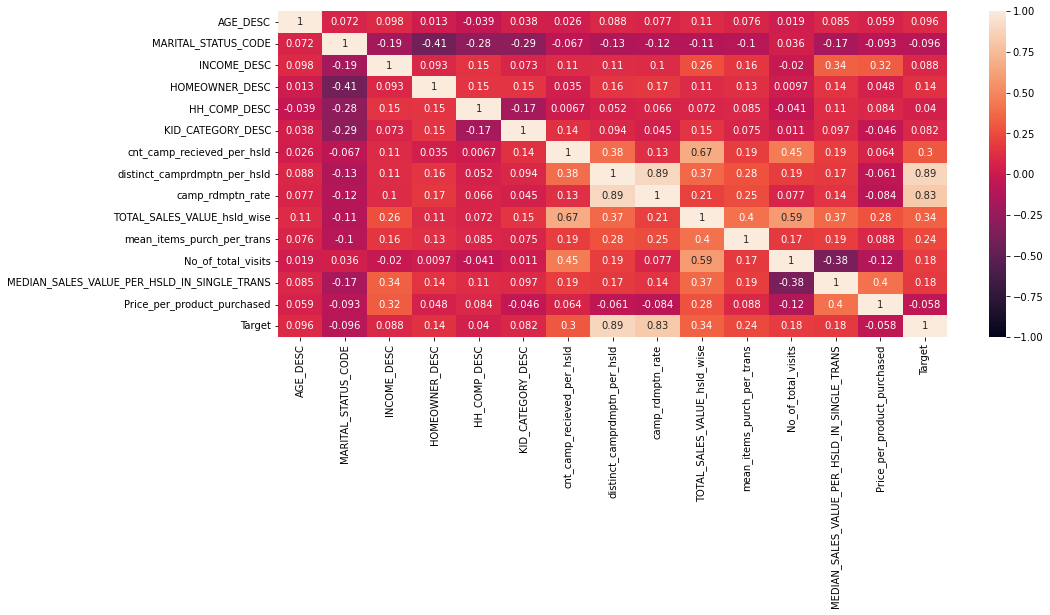

In [1249]:
# correlation plot after encoding and scalling.
plt.figure(figsize=(15,6))
sns.heatmap(pd.concat((X,y),axis=1).corr(),annot=True,vmin=-1,vmax=+1)
plt.show()

#  Modeling

In [1250]:
from statsmodels.api import Logit, add_constant

In [1251]:
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, classification_report

lr=LogisticRegression()
knn=KNeighborsClassifier()
nb=GaussianNB()
dt=DecisionTreeClassifier()
rfc=RandomForestClassifier()
ada=AdaBoostClassifier()
gbm=GradientBoostingClassifier()
xgb=XGBClassifier()
cat=CatBoostClassifier()
lgbm=LGBMClassifier()
mdls=[dt,nb,knn,rfc,ada,gbm,xgb,lgbm]

In [1252]:
mdls

[DecisionTreeClassifier(),
 GaussianNB(),
 KNeighborsClassifier(),
 RandomForestClassifier(),
 AdaBoostClassifier(),
 GradientBoostingClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 LGBMClassifier()]

In [1253]:
xtrain_c = add_constant(xtrain) 
xtest_c = add_constant(xtest)

In [1254]:
base_model = Logit(ytrain,xtrain_c).fit()

PerfectSeparationError: Perfect separation detected, results not available

In [1255]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                  608
Model:                          Logit   Df Residuals:                      592
Method:                           MLE   Df Model:                           15
Date:                Fri, 31 Mar 2023   Pseudo R-squ.:                  0.9994
Time:                        21:04:17   Log-Likelihood:               -0.25816
converged:                      False   LL-Null:                       -411.43
Covariance Type:            nonrobust   LLR p-value:                1.436e-165
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          25.3541    323.571      0.078      0.938    -608.834     659.542
AGE_DESC                                      -20.9215    317.758     -0.066      0.948    -643.716     601.873
MARITAL_STATUS_CODE                            -6.6024    119.638     -0.055      0.956    -241.089     227.884
INCOME_DESC                                     1.1665     14.522      0.080      0.936     -27.297      29.630
HOMEOWNER_DESC                                  5.4353    165.064      0.033      0.974    -318.084     328.955
HH_COMP_DESC                                  -49.8100   1008.843     -0.049      0.961   -2027.107    1927.487
KID_CATEGORY_DESC                              -5.4639     81.439     -0.067      0.947    -165.081     154.153
cnt_camp_recieved_per_hsld                      6.3010    196.527      0.032      0.974    -378.885     391.487
distinct_camprdmptn_per_hsld                   27.9580    288.017      0.097      0.923    -536.545     592.461
camp_rdmptn_rate                               28.1617    626.675      0.045      0.964   -1200.099    1256.422
TOTAL_SALES_VALUE_hsld_wise                     0.3524    136.846      0.003      0.998    -267.861     268.565
mean_items_purch_per_trans                      2.3650     45.599      0.052      0.959     -87.007      91.737
No_of_total_visits                             -0.7982    174.659     -0.005      0.996    -343.123     341.527
MEAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS      -2.0221    140.362     -0.014      0.989    -277.126     273.082
MEDIAN_SALES_VALUE_PER_HSLD_IN_SINGLE_TRANS    -1.5761    171.091     -0.009      0.993    -336.908     333.755
Price_per_product_purchased                    -0.8270    102.770     -0.008      0.994    -202.253     200.599
===============================================================================================================

Possibly complete quasi-separation: A fraction 0.98 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [1256]:
dic1=pd.DataFrame()
j=0;
l1=['dt','nb','knn','rfc','ada','gbm','xgb','lgbm']
for i in mdls[:-1]:
    m=i.fit(xtrain,ytrain)
    pred=m.predict(xtest)
    print(i,':')
    print(confusion_matrix(ytest,pred))
    dic1.loc[j,'Model']=l1[j]
    dic1.loc[j,'accuracy_score']=accuracy_score(ytest,pred)
    dic1.loc[j,'f1_score']=f1_score(ytest,pred)
    dic1.loc[j,'recall_score']=recall_score(ytest,pred)
    dic1.loc[j,'precision_score']=precision_score(ytest,pred)
    j+=1
    print()

DecisionTreeClassifier() :
[[90  0]
 [ 0 62]]

GaussianNB() :
[[90  0]
 [ 0 62]]

KNeighborsClassifier() :
[[88  2]
 [ 3 59]]

RandomForestClassifier() :
[[90  0]
 [ 0 62]]

AdaBoostClassifier() :
[[90  0]
 [ 0 62]]

GradientBoostingClassifier() :
[[90  0]
 [ 0 62]]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, rand

In [1257]:
dic1.sort_values(['accuracy_score','f1_score'],ascending=False)

,Model,accuracy_score,f1_score,recall_score,precision_score
0,dt,1.000000,1.00000,1.000000,1.000000
1,nb,1.000000,1.00000,1.000000,1.000000
3,rfc,1.000000,1.00000,1.000000,1.000000
4,ada,1.000000,1.00000,1.000000,1.000000
5,gbm,1.000000,1.00000,1.000000,1.000000
6,xgb,1.000000,1.00000,1.000000,1.000000
2,knn,0.967105,0.95935,0.951613,0.967213


In [1258]:
Extracted_tables_info

,Tables Extracted,Information Derived
0,cnt_camp_recieved_per_hsld,count of campaign recieved per household
1,distinct_camprdmptn_per_hsld,coupons of distinct campaign redempt by specif...
2,cnt_of_camp_recieved_by_num_of_hsld,number of campaign recieved by number of house...
3,camp_rdmptn_rate,rate of redemption of each household
4,cpnrdmpt_campwise,Coupon redemption campaign wise
5,hsld_wise_ttlsales,total purchase done by each household during t...
6,No_of_items_in_single_trans,total number of transactions and number of pro...
7,mean_items_purch_per_trans,average number of products purchased per trans...
8,No_of_total_visits,total number of visits of each households
9,amt_spent_single_trans,amount spent in a single transaction
